In [1]:
%load_ext autoreload
%autoreload 2
import sys
path='../'
if not path in sys.path:
    
    sys.path.append(path)

In [23]:
import pandas as pd
import numpy as np
from scripts.data_preprocessing import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

## Data Understanding

### Data Pre-Processing
Data preprocessing is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn; therefore, it is extremely important that we preprocess our data before feeding it into our model.

We'll look at:


*   Handling Null Values
*   Standardization

Others:


*   Handling Categorical Variables
*   One-Hot Encoding

Reference: [https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d](https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d)

In [6]:
df = pd.read_csv('../data/diabetic_data.csv', na_values=['?', None])
df.head()

/var/folders/dp/57y4rbx55kxdswwsnmzgp_j40000gn/T/ipykernel_2898/507263473.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/diabetic_data.csv', na_values=['?', None])


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
percent_missing(df)

The Diabetes dataset contains 7.35 % missing values.


In [10]:
# drop columns with more than 30% missing values
df_clean = df.drop(['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'], axis=1)
df_clean.shape

(101766, 45)

In [11]:

df_clean['diag_1'] = fix_missing_ffill(df_clean, 'diag_1')
df_clean['diag_2'] = fix_missing_ffill(df_clean, 'diag_2')
df_clean['diag_3'] = fix_missing_ffill(df_clean, 'diag_3')

# fill 'race' column with mode
df_clean['race'] = df_clean['race'].fillna(df_clean['race'].mode()[0])

In [12]:
df_clean.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [13]:
df_clean=df_clean.drop(['encounter_id', 'patient_nbr', 'age'], axis=1)
df_clean.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,6,25,1,1,41,0,1,0,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,1,1,7,3,59,0,18,0,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,1,1,7,2,11,5,13,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,1,1,7,2,44,1,16,0,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,1,1,7,1,51,0,8,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [14]:
df_clean.isnull().sum()

race                        0
gender                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      1
diag_3                      1
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [15]:
df_clean['diag_1'] = df_clean['diag_1'].apply (pd.to_numeric, errors='coerce')
df_clean['diag_2'] = df_clean['diag_2'].apply (pd.to_numeric, errors='coerce')
df_clean['diag_3'] = df_clean['diag_3'].apply (pd.to_numeric, errors='coerce')

In [16]:
df_clean.dropna(subset = ['diag_1',"diag_2",'diag_3'], inplace=True)
df_clean.isnull().sum()

race                        0
gender                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [17]:

lb = LabelEncoder()
df_clean['metformin'] = lb.fit_transform(df_clean['metformin'])
df_clean['repaglinide'] = lb.fit_transform(df_clean['repaglinide'])
df_clean['nateglinide'] = lb.fit_transform(df_clean['nateglinide'])
df_clean['chlorpropamide'] = lb.fit_transform(df_clean['chlorpropamide'])
df_clean['glimepiride'] = lb.fit_transform(df_clean['glimepiride'])
df_clean['acetohexamide'] = lb.fit_transform(df_clean['acetohexamide'])
df_clean['glipizide'] = lb.fit_transform(df_clean['glipizide'])
df_clean['glyburide'] = lb.fit_transform(df_clean['glyburide'])
df_clean['tolbutamide'] = lb.fit_transform(df_clean['tolbutamide'])
df_clean['pioglitazone'] = lb.fit_transform(df_clean['pioglitazone'])
df_clean['rosiglitazone'] = lb.fit_transform(df_clean['rosiglitazone'])

df_clean['acarbose'] = lb.fit_transform(df_clean['acarbose'])
df_clean['miglitol'] = lb.fit_transform(df_clean['miglitol'])
df_clean['troglitazone'] = lb.fit_transform(df_clean['troglitazone'])
df_clean['tolazamide'] = lb.fit_transform(df_clean['tolazamide'])
df_clean['examide'] = lb.fit_transform(df_clean['examide'])
df_clean['citoglipton'] = lb.fit_transform(df_clean['citoglipton'])
df_clean['insulin'] = lb.fit_transform(df_clean['insulin'])
df_clean['glyburide-metformin'] = lb.fit_transform(df_clean['glyburide-metformin'])
df_clean['glipizide-metformin'] = lb.fit_transform(df_clean['glipizide-metformin'])


df_clean['glimepiride-pioglitazone'] = lb.fit_transform(df_clean['glimepiride-pioglitazone'])
df_clean['metformin-rosiglitazone'] = lb.fit_transform(df_clean['metformin-rosiglitazone'])
df_clean['metformin-pioglitazone'] = lb.fit_transform(df_clean['metformin-pioglitazone'])
df_clean['change'] = lb.fit_transform(df_clean['change'])
df_clean['diabetesMed'] = lb.fit_transform(df_clean['diabetesMed'])
df_clean['readmitted'] = lb.fit_transform(df_clean['readmitted'])
df_clean['race'] = lb.fit_transform(df_clean['race'])
df_clean['gender'] = lb.fit_transform(df_clean['gender'])
df_clean.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,2,0,1,1,7,3,59,0,18,0,...,0,3,1,0,0,0,0,0,1,1
3,2,1,1,1,7,2,44,1,16,0,...,0,3,1,0,0,0,0,0,1,2
4,2,1,1,1,7,1,51,0,8,0,...,0,2,1,0,0,0,0,0,1,2
5,2,1,2,1,2,3,31,6,16,0,...,0,2,1,0,0,0,0,1,1,1
7,2,1,1,1,7,5,73,0,12,0,...,0,1,1,0,0,0,0,1,1,1


In [18]:
y= df_clean['readmitted']
len(y)

93225

In [20]:
x = df_clean.drop(['readmitted'],axis=1)
len(x)

93225

[3.155e-01 1.729e+01 1.533e+01 2.604e+03 4.313e+02 6.592e+02 1.311e+03
 4.120e+02 1.007e+03 2.917e+03 4.495e+03 1.261e+04 2.731e+03 1.971e+02
 4.372e+03 6.086e+02 1.299e+01 6.560e-01 8.625e-03 4.112e-03 4.664e-01
 1.858e+00 2.670e+00 5.309e-02 1.644e+00 1.589e+00 1.646e+00 8.551e-02
 1.072e-03 1.429e+00 1.061e+00       nan       nan 2.342e-01 7.301e-03
 9.282e-01 1.858e+00 1.711e+00 8.553e-01 9.501e+01 8.457e+01]
Feature 0: 0.315502
Feature 1: 17.287898
Feature 2: 15.332621
Feature 3: 2604.256923
Feature 4: 431.318206
Feature 5: 659.230439
Feature 6: 1310.768572
Feature 7: 411.979262
Feature 8: 1007.322951
Feature 9: 2917.156922
Feature 10: 4494.822055
Feature 11: 12606.231712
Feature 12: 2731.357116
Feature 13: 197.119252
Feature 14: 4372.027070
Feature 15: 608.635958
Feature 16: 12.986065
Feature 17: 0.656015
Feature 18: 0.008625
Feature 19: 0.004112
Feature 20: 0.466355
Feature 21: 1.857909
Feature 22: 2.669720
Feature 23: 0.053091
Feature 24: 1.644012
Feature 25: 1.588770
Feature 2

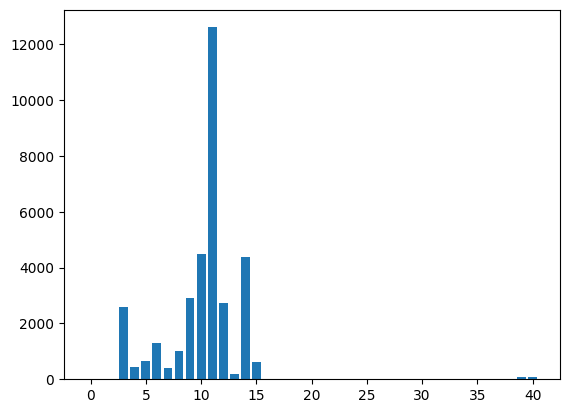

[[  0.   0.   0. 255.]
 [  0.   0.   0. 403.]
 [  0.   0.   0. 250.]
 [  0.   0.   0. 250.]
 [  0.   0.   0. 250.]]


In [25]:
select_features(x,y)

In [26]:
selected_features=x[['discharge_disposition_id', 'time_in_hospital', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed']]
len(selected_features)

93225

In [27]:
selected_features.head()

,discharge_disposition_id,time_in_hospital,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed
1,1,3,18,0,0,0,9,0,1
3,1,2,16,0,0,0,7,0,1
4,1,1,8,0,0,0,5,0,1
5,1,3,16,0,0,0,9,1,1
7,1,5,12,0,0,0,8,1,1


In [28]:
len(y)

93225

In [30]:
y.to_csv('../data/label.csv')
selected_features.to_csv('../data/features.csv')